# [ACN-Sim Tutorial: Lesson 2][acn-sim_2]

## Implementing a Custom Algorithm

### by Zachary Lee
### Last updated: 03/19/2019



[acn-sim_2]: https://acnportal.readthedocs.io/en/latest/tutorials/acnsim/lesson2.html#ACN-Sim-Tutorial:-Lesson-2

In this lesson we will learn how to develop a custom algorithm and run it using ACN-Sim. 
For this example we will be writing an Earliest Deadline First Algorithm. 

This algorithm is already available as part of the SortingAlgorithm in the algorithms package, so we will compare the results of our implementation with the included one.

## [Custom Algorithm][acn-sim_2-cust_alg]

All custom algorithms should inherit from the abstract class BaseAlgorithm. It is the responsibility of all derived classes to implement the schedule method. This method takes as an input a list of EVs which are currently connected to the system but have not yet finished charging. Its output is a dictionary which maps a station_id to a list of charging rates. Each charging rate is valid for one period measured relative to the current period.

For Example: * schedule[‘abc’][0] is the charging rate for station ‘abc’ during the current period * schedule[‘abc’][1] is the charging rate for the next period * and so on.

If an algorithm only produces charging rates for the current time period, the length of each list should be 1. If this is the case, make sure to also set the maximum resolve period to be 1 period so that the algorithm will be called each period. An alternative is to repeat the charging rate a number of times equal to the max recompute period.

As mentioned previously our new algorithm should inherit from BaseAlgorithm or a subclass of it.

We can override the init() method if we need to pass additional configuration information to the algorithm. In this case we pass in the increment which will be used when searching for a feasible rate.

We next need to override the schedule() method. The signature of this method should remain the same, as it is called internally in Simulator. If an algorithm needs additional parameters consider passing them through the constructor.

[acn-sim_2-cust_alg]: https://acnportal.readthedocs.io/en/latest/tutorials/acnsim/lesson2.html#Custom-Algorithm

In [1]:
from acnportal.algorithms import BaseAlgorithm

class EarliestDeadlineFirstAlgo(BaseAlgorithm):
    """ Algorithm which assigns charging rates to each EV in order of
    estimated departure time.

    Implements abstract class BaseAlgorithm.

    For this algorithm EVs will first be sorted by estimated departure time. We will
    then allocate as much
    current as possible to each EV in order until the EV is finished charging or an infrastructure
    limit is met.

    Args:
        increment (number): Minimum increment of charging rate. Default: 1.
    """
    def __init__(self, increment=1):
        super().__init__()
        self._increment = increment
        self.max_recompute = 1

    def schedule(self, active_evs):
        schedule = {ev.station_id: [0] for ev in active_evs}

        # Next, we sort the active_evs by their estimated departure time.
        sorted_evs = sorted(active_evs, key=lambda x: x.estimated_departure)

        # We now iterate over the sorted list of EVs.
        for ev in sorted_evs:
            # First try to charge the EV at its maximum rate. Remember that each schedule value
            #   must be a list, even if it only has one element.
            schedule[ev.station_id] = [self.interface.max_pilot_signal(ev.station_id)]

            # If this is not feasible, we will reduce the rate.
            #   interface.is_feasible() is one way to interact with the constraint set
            #   of the network. We will explore another more direct method in lesson 3.
            while not self.interface.is_feasible(schedule, 0):

                # Since the maximum rate was not feasible, we should try a lower rate.
                schedule[ev.station_id][0] -= self._increment

                # EVs should never charge below 0 (i.e. discharge) so we will clip the value at 0.
                if schedule[ev.station_id][0] < 0:
                    schedule[ev.station_id] = [0]
                    break
        return schedule

Note the structure of the schedule dict which is returned should be something like:


```
{  
    'CA-301': [32, 32, 32, 16, 16, ..., 8],  
    'CA-302': [8, 13, 13, 15, 6, ..., 0],  
    ...,  
    'CA-408': [24, 24, 24, 24, 0, ..., 0]  
}  
```

For the special case when an algorithm only calculates a target rate for the next time interval instead of an entire schedule of rates, the structure should be:

```
{  
    'CA-301': [32],  
    'CA-302': [8],  
    ...,  
    'CA-408': [24]  
}  
```

Note that these are single element lists and NOT floats or integers.

## [Running the Algorithm][acn-sim_2-run_alg]

Now that we have implemented our algorithm, we can try it out using the same experiment setup as in lesson 1. 

The only difference will be which scheduling algorithm we use. For fun, lets compare our algorithm against to included implementation of the earliest deadline first algorithm.

[acn-sim_2-run_alg]: https://acnportal.readthedocs.io/en/latest/tutorials/acnsim/lesson2.html#Running-the-Algorithm

In [2]:
from datetime import datetime

import os
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from copy import deepcopy

from acnportal import algorithms
from acnportal import acnsim


# -- Experiment Parameters ---------------------------------------------------------------------------------------------
timezone = pytz.timezone('America/Los_Angeles')
start = timezone.localize(datetime(2018, 9, 5))
end = timezone.localize(datetime(2018, 9, 6))
period = 5  # minute
voltage = 220  # volts
default_battery_power = 32 * voltage / 1000 # kW
site = 'caltech'

# -- Network -----------------------------------------------------------------------------------------------------------
cn = acnsim.sites.caltech_acn(basic_evse=True, voltage=voltage)

# -- Events ------------------------------------------------------------------------------------------------------------
API_KEY = os.getenv('API_KEY')
events = acnsim.acndata_events.generate_events(API_KEY, site, start, end, period, voltage, default_battery_power)


# -- Scheduling Algorithm ----------------------------------------------------------------------------------------------
sch = EarliestDeadlineFirstAlgo(increment=1)
sch2 = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)

In [3]:
# -- Simulator ---------------------------------------------------------------------------------------------------------
sim = acnsim.Simulator(deepcopy(cn), sch, deepcopy(events), start, period=period, verbose=False)
sim.run()

In [4]:
# For comparison we will also run the builtin earliest deadline first algorithm
sim2 = acnsim.Simulator(deepcopy(cn), sch2, deepcopy(events), start, period=period, verbose=False)
sim2.run()

## [Results][acn-sim_2-results]

We can now compare the two algorithms side by side by looking that the plots of aggregated current. 

We see from these plots that our implementation matches th included one quite well. 
If we look closely however, we might see a small difference. This is because the included algorithm uses a more efficient bisection based method instead of our simpler linear search to find a feasible rate.

[acn-sim_2-results]: https://acnportal.readthedocs.io/en/latest/tutorials/acnsim/lesson2.html#Results

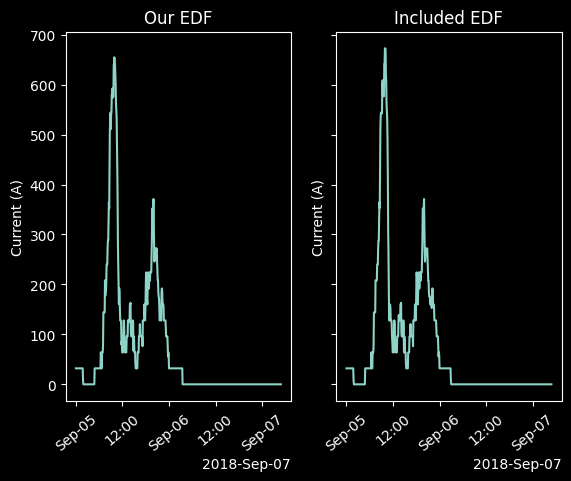

In [5]:
# Get list of datetimes over which the simulations were run.
sim_dates = mdates.date2num(acnsim.datetimes_array(sim))
sim2_dates = mdates.date2num(acnsim.datetimes_array(sim2))

# Set locator and formatter for datetimes on x-axis.
locator = mdates.AutoDateLocator(maxticks=6)
formatter = mdates.ConciseDateFormatter(locator)

fig, axs = plt.subplots(1, 2, sharey=True, sharex=True)
axs[0].plot(sim_dates, acnsim.aggregate_current(sim), label='Our EDF')
axs[1].plot(sim2_dates, acnsim.aggregate_current(sim2), label='Included EDF')
axs[0].set_title('Our EDF')
axs[1].set_title('Included EDF')
for ax in axs:
    ax.set_ylabel('Current (A)')
    for label in ax.get_xticklabels():
        label.set_rotation(40)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

plt.show()